# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

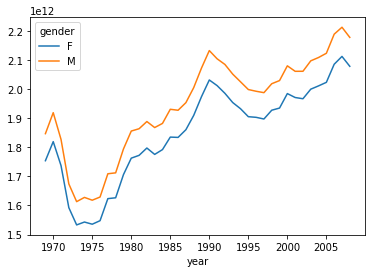

In [2]:
df = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/data/births.csv')
df['births_plot'] = df['births'] * 1e6
df['day'] = df['day'].fillna(0)
df.groupby(['year','gender']).births_plot.sum().unstack().plot()

In [3]:
df

,year,month,day,gender,births,births_plot
0,1969,1,1.0,F,4046,4.046000e+09
1,1969,1,1.0,M,4440,4.440000e+09
2,1969,1,2.0,F,4454,4.454000e+09
3,1969,1,2.0,M,4548,4.548000e+09
4,1969,1,3.0,F,4548,4.548000e+09
...,...,...,...,...,...,...
15542,2008,10,0.0,M,183219,1.832190e+11
15543,2008,11,0.0,F,158939,1.589390e+11
15544,2008,11,0.0,M,165468,1.654680e+11
15545,2008,12,0.0,F,173215,1.732150e+11


# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [4]:
"""
Plot.1

The first plot shows the number of births by year on each day, with a mean component showing
where the average is and its fluctuations.

"""

'\nPlot.1\n\nThe first plot shows the number of births by year on each day, with a mean component showing\nwhere the average is and its fluctuations.\n\n'

In [5]:
"""
plot.2

This plot shows the periodic change in time for births.
A periodic function repeats values at set intervals, showing the change in time.
"""

'\nplot.2\n\nThis plot shows the periodic change in time for births.\nA periodic function repeats values at set intervals, showing the change in time.\n'

In [6]:
"""
plot.3

The residual graph shows and measures how often the regression line vertically misses
a data point from the first graph.


"""

'\nplot.3\n\nThe residual graph shows and measures how often the regression line vertically misses\na data point from the first graph.\n\n\n'

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

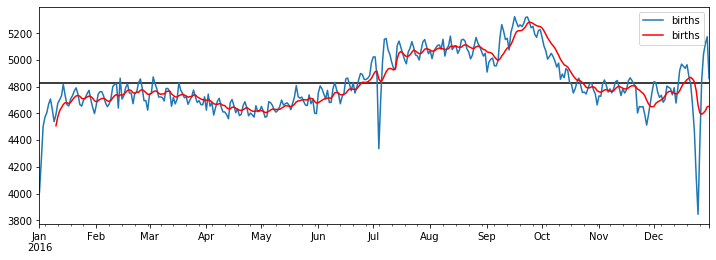

In [7]:
import datetime as dt
import warnings

warnings.filterwarnings('ignore')
df = df[~df.day.isin([0])]
df['date'] = pd.to_datetime(10000 * df.year +
                            100 * df.month +
                            df.day, format='%Y%m%d', errors='coerce')
quartiles = np.percentile(df['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
df['day'] = df['day'].astype(int)


df.index = pd.to_datetime(10000 * df.year +
                          100 * df.month +
                          df.day, format='%Y%m%d')
df = df.pivot_table('births', [df.index.month, df.index.day])

df.index = [pd.datetime(2016, month, day)
                        for (month, day) in df.index]

fig, ax = plt.subplots(figsize=(12, 4))
df.plot(ax=ax)
df.rolling(window=10).mean().plot(color='r', ax=ax)
ax.hlines(df.births.mean(),df.index[0],df.index[-1],color = 'black')


# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [8]:
import json
import gzip
import numpy as np
import pandas as pd

In [9]:
with gzip.open('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/recipe.json.gz','r') as f:
    try:
        recipes = pd.read_json(f)
    except ValueError as e:
        print("ValueError:", e)


ValueError: Trailing data


In [10]:
with gzip.open('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/recipe.json.gz', 'r') as f:
    line = f.readline()


In [11]:

with gzip.open('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/recipe.json.gz', 'r') as f:

    data = (line.strip().decode() for line in f)

    data_json = f"[{','.join(data)}]"

recipes = pd.read_json(data_json)
recipes.description.str.contains('[Bb]reakfast').sum()

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [12]:
recipes['salt'] = recipes.ingredients.str.contains('[Ss]alt')
recipes['pepper'] = recipes.ingredients.str.contains('[Pp]epper')
recipes['oregano'] = recipes.ingredients.str.contains('oregano')
recipes['sage'] = recipes.ingredients.str.contains('sage')
recipes['parsley'] = recipes.ingredients.str.contains('parsley')
recipes['rosemary'] = recipes.ingredients.str.contains('rosemary')
recipes['tarragon'] = recipes.ingredients.str.contains('tarragon')
recipes['thyme'] = recipes.ingredients.str.contains('thyme')
recipes['paprika'] = recipes.ingredients.str.contains('paprika')
recipes['cumin'] = recipes.ingredients.str.contains('cumin')


In [33]:
recommend_ingredients = recipes.loc[(recipes['parsley'] == True) & (recipes['paprika'] == True) & (recipes['tarragon'] == True)]
recommend_ingredients.index

Int64Index([2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175,
            165243],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [13]:
ratings = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/ratings.csv')
movies = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/movies_metadata.csv')
credit = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/m2-3-exploration/credits.csv')

credit["cast"] = credit['cast'].str.replace('[^\w\s]','')
test = credit.groupby(['cast', 'id']).count()
test


crew
cast                                               id          
                                                   774        1
                                                   3171       1
                                                   8770       1
                                                   8893       1
                                                   10000      1
...                                                         ...
cast_id 9 character ефрейтор Виктор Святкин cre... 72614      1
cast_id 9 character 무명 Mumyeong credit_id 5319d... 41441      1
cast_id 94 character Corrine Maguire credit_id ... 24617      1
cast_id 96 character Kenai voice credit_id 575f... 10009      1
cast_id 99 character Wade Wilson  Deadpool cred... 293660     1

[45432 rows x 1 columns]